In [3]:
"""
Import all necessary libraries for audio processing, machine learning, and visualization
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from keras import layers
import librosa
import librosa.display
import os
import warnings
from IPython.display import Audio, display
import joblib

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')



In [ ]:
class MusicGenreClassifier:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_columns = [
            'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
            'rolloff', 'zero_crossing_rate'
        ] + [f'mfcc{i}' for i in range(1, 21)]
        self.history = None
    
    def extract_features(self, file_path, duration=30):
        """
        Extract comprehensive audio features from a music file
        """
        try:
            # Load audio file (limit to 30 seconds for faster processing)
            audio, sample_rate = librosa.load(file_path, duration=duration)
            
            # Initialize features dictionary
            features = {}
            
            # 1. Chroma features (pitch class profiles)
            chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
            features['chroma_stft'] = np.mean(chroma_stft)
            
            # 2. Root Mean Square Energy
            rmse = librosa.feature.rms(y=audio)  
            features['rmse'] = np.mean(rmse)
            
            # 3. Spectral centroid (brightness of sound)
            spec_cent = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
            features['spectral_centroid'] = np.mean(spec_cent)
            
            # 4. Spectral bandwidth
            spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
            features['spectral_bandwidth'] = np.mean(spec_bw)
            
            # 5. Spectral rolloff
            rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
            features['rolloff'] = np.mean(rolloff)
            
            # 6. Zero crossing rate
            zcr = librosa.feature.zero_crossing_rate(audio)
            features['zero_crossing_rate'] = np.mean(zcr)
            
            # 7. MFCC features (most important for genre classification)
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
            for i in range(20):
                features[f'mfcc{i+1}'] = np.mean(mfcc[i])
            
            return features
            
        except Exception as e:
            print(f"❌ Error processing {file_path}: {e}")
            return None
    
    def visualize_audio_features(self, file_path):
        """
        Visualize audio features for understanding
        """
        audio, sr = librosa.load(file_path, duration=30)
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Audio Analysis: {os.path.basename(file_path)}', fontsize=16)
        
        # Waveform
        axes[0,0].plot(audio[:sr*3])  # First 3 seconds
        axes[0,0].set_title('Waveform')
        axes[0,0].set_xlabel('Samples')
        
        # Spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[0,1])
        axes[0,1].set_title('Spectrogram')
        
        # MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=axes[0,2])
        axes[0,2].set_title('MFCC')
        
        # Chroma
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', ax=axes[1,0])
        axes[1,0].set_title('Chroma')
        
        # Spectral centroid
        cent = librosa.feature.spectral_centroid(y=audio, sr=sr)
        axes[1,1].plot(cent[0])
        axes[1,1].set_title('Spectral Centroid')
        axes[1,1].set_xlabel('Frames')
        
        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        axes[1,2].plot(zcr[0])
        axes[1,2].set_title('Zero Crossing Rate')
        axes[1,2].set_xlabel('Frames')
        
        plt.tight_layout()
        plt.show()
        
        return Audio(audio, rate=sr)
    
    def load_dataset(self, data_path, sample_limit=None):
        """
        Load and process music dataset with progress tracking
        """
        features_list = []
        labels = []
        file_count = 0
        
        print("🎵 Loading and processing audio files...")
        print("=" * 50)
        
        for genre in sorted(os.listdir(data_path)):
            genre_path = os.path.join(data_path, genre)
            if os.path.isdir(genre_path):
                files = [f for f in os.listdir(genre_path) if f.endswith(('.wav', '.mp3', '.flac'))]
                
                if sample_limit:
                    files = files[:sample_limit]
                
                print(f"📁 Processing {genre}: {len(files)} files")
                
                for i, file in enumerate(files):
                    file_path = os.path.join(genre_path, file)
                    features = self.extract_features(file_path)
                    
                    if features:
                        features_list.append(features)
                        labels.append(genre)
                        file_count += 1
                    
                    # Progress indicator
                    if (i + 1) % 10 == 0:
                        print(f"  ✓ Processed {i + 1}/{len(files)} files")
        
        print(f"✅ Successfully processed {file_count} files")
        
        # Convert to DataFrame
        df = pd.DataFrame(features_list)
        df['genre'] = labels
        
        return df
    
    def explore_dataset(self, df):
        """
        Explore and visualize the dataset
        """
        print("📊 Dataset Overview:")
        print("=" * 50)
        print(f"Total samples: {len(df)}")
        print(f"Features: {len(self.feature_columns)}")
        print(f"Genres: {df['genre'].nunique()}")
        print("\nGenre distribution:")
        print(df['genre'].value_counts())
        
        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Genre distribution
        df['genre'].value_counts().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Genre Distribution')
        axes[0,0].set_xlabel('Genre')
        axes[0,0].set_ylabel('Count')
        
        # Feature correlation heatmap (first 10 features)
        feature_subset = ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 
                         'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4']
        corr_matrix = df[feature_subset].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[0,1])
        axes[0,1].set_title('Feature Correlation (Subset)')
        
        # MFCC distribution by genre
        df.boxplot(column='mfcc1', by='genre', ax=axes[1,0])
        axes[1,0].set_title('MFCC1 Distribution by Genre')
        
        # Spectral centroid by genre
        df.boxplot(column='spectral_centroid', by='genre', ax=axes[1,1])
        axes[1,1].set_title('Spectral Centroid by Genre')
        
        plt.tight_layout()
        plt.show()
        
        return df.describe()
    
    def prepare_data(self, df, test_size=0.2):
        """
        Prepare data for training with detailed information
        """
        print("🔧 Preparing data for training...")
        
        # Separate features and labels
        X = df[self.feature_columns].values
        y = df['genre'].values
        
        print(f"Feature matrix shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        print(f"Unique genres: {list(self.label_encoder.classes_)}")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
        )
        
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        print("✅ Data preparation completed!")
        
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def build_model(self, input_dim, num_classes):
        """
        Build optimized neural network model
        """
        model = keras.Sequential([
            # Input layer with batch normalization
            layers.Dense(2048, activation='relu', input_shape=(input_dim)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            
            # Hidden layers
            layers.Dense(1024, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.2),
            
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),

            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),

            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            
            # Output layer
            layers.Dense(num_classes, activation='softmax')
        ])
        
        # Compile with Adam optimizer
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train(self, df, epochs=100, batch_size=32, validation_split=0.2):
        """
        Train the model with comprehensive monitoring
        """
        print("🚀 Starting model training...")
        print("=" * 50)
        
        # Prepare data
        X_train, X_test, y_train, y_test = self.prepare_data(df)
        
        # Build model
        num_classes = len(self.label_encoder.classes_)
        self.model = self.build_model(X_train.shape[1], num_classes)
        
        print("🏗️ Model Architecture:")
        self.model.summary()
        
        # Setup callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=8,
                min_lr=0.00001,
                verbose=1
            )
        ]
        
        # Train model
        print("🎯 Training in progress...")
        self.history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # Final evaluation
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"\n🎉 Final Test Accuracy: {test_accuracy:.4f}")
        
        # Detailed classification report
        y_pred = self.model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        print("\n📊 Detailed Classification Report:")
        print("=" * 50)
        print(classification_report(
            y_test, y_pred_classes,
            target_names=self.label_encoder.classes_,
            digits=4
        ))
        
        return self.history, (X_test, y_test, y_pred_classes)
    
    def plot_training_history(self):
        """
        Visualize training progress
        """
        if self.history is None:
            print("❌ No training history available. Train the model first!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Training & validation accuracy
        axes[0,0].plot(self.history.history['accuracy'], label='Training Accuracy', linewidth=2)
        axes[0,0].plot(self.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        axes[0,0].set_title('Model Accuracy Over Time')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Training & validation loss
        axes[0,1].plot(self.history.history['loss'], label='Training Loss', linewidth=2)
        axes[0,1].plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0,1].set_title('Model Loss Over Time')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Learning rate (if available)
        if 'lr' in self.history.history:
            axes[1,0].plot(self.history.history['lr'], linewidth=2)
            axes[1,0].set_title('Learning Rate Schedule')
            axes[1,0].set_xlabel('Epoch')
            axes[1,0].set_ylabel('Learning Rate')
            axes[1,0].set_yscale('log')
            axes[1,0].grid(True, alpha=0.3)
        
        # Final epoch metrics
        final_metrics = {
            'Train Acc': self.history.history['accuracy'][-1],
            'Val Acc': self.history.history['val_accuracy'][-1],
            'Train Loss': self.history.history['loss'][-1],
            'Val Loss': self.history.history['val_loss'][-1]
        }
        
        axes[1,1].bar(final_metrics.keys(), final_metrics.values())
        axes[1,1].set_title('Final Epoch Metrics')
        axes[1,1].set_ylabel('Value')
        for i, v in enumerate(final_metrics.values()):
            axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center')
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Genre')
        plt.ylabel('True Genre')
        plt.show()
    
    def predict_genre(self, file_path):
        """
        Predict genre of a single audio file with confidence scores
        """
        if self.model is None:
            raise ValueError("❌ Model not trained yet!")
        
        print(f"🎵 Analyzing: {os.path.basename(file_path)}")
        
        features = self.extract_features(file_path)
        if features is None:
            return None
        
        # Prepare features
        feature_vector = np.array([features[col] for col in self.feature_columns])
        feature_vector = self.scaler.transform([feature_vector])
        
        # Predict
        prediction = self.model.predict(feature_vector, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        
        genre = self.label_encoder.inverse_transform([predicted_class])[0]
        
        # Create probability distribution
        probabilities = dict(zip(self.label_encoder.classes_, prediction[0]))
        sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
        
        print(f"🎯 Predicted Genre: {genre}")
        print(f"🔥 Confidence: {confidence:.3f}")
        print("\n📊 All Genre Probabilities:")
        for genre_name, prob in sorted_probs:
            print(f"  {genre_name}: {prob:.3f}")
        
        return {
            'genre': genre,
            'confidence': confidence,
            'probabilities': probabilities
        }
    
    def save_model(self, model_path):
        """Save the complete model and preprocessors"""
        self.model.save(f"{model_path}_model.h5")
        joblib.dump(self.scaler, f"{model_path}_scaler.pkl")
        joblib.dump(self.label_encoder, f"{model_path}_encoder.pkl")
        print(f"✅ Model saved as {model_path}_*")
    
    def load_model(self, model_path):
        """Load a pre-trained model"""
        self.model = keras.models.load_model(f"{model_path}_model.h5")
        self.scaler = joblib.load(f"{model_path}_scaler.pkl")
        self.label_encoder = joblib.load(f"{model_path}_encoder.pkl")
        print(f"✅ Model loaded from {model_path}_*")

In [5]:
"""
Create an instance of our Music Genre Classifier
"""

print("🎵 Initializing Music Genre Classifier...")
classifier = MusicGenreClassifier()
print("✅ Classifier ready!")

🎵 Initializing Music Genre Classifier...
✅ Classifier ready!


In [6]:
"""
Configure your dataset path and parameters
"""

# IMPORTANT: Update this path to your dataset location
DATASET_PATH = "./dataset"  # Change this!

SAMPLE_LIMIT = None  # Set to a number to limit files per genre (e.g., 50)
EPOCHS = 1000  # Number of training epochs
BATCH_SIZE = 32

print("📁 Dataset Configuration:")
print(f"  Path: {DATASET_PATH}")
print(f"  Sample limit per genre: {SAMPLE_LIMIT or 'No limit'}")
print(f"  Training epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")


📁 Dataset Configuration:
  Path: ./dataset
  Sample limit per genre: No limit
  Training epochs: 1000
  Batch size: 32


🎵 Loading and processing audio files...
📁 Processing blues: 100 files


  ✓ Processed 10/100 files
  ✓ Processed 20/100 files
  ✓ Processed 30/100 files
  ✓ Processed 40/100 files
  ✓ Processed 50/100 files
  ✓ Processed 60/100 files
  ✓ Processed 70/100 files
  ✓ Processed 80/100 files
  ✓ Processed 90/100 files
  ✓ Processed 100/100 files
📁 Processing classical: 100 files
  ✓ Processed 10/100 files
  ✓ Processed 20/100 files
  ✓ Processed 30/100 files
  ✓ Processed 40/100 files
  ✓ Processed 50/100 files
  ✓ Processed 60/100 files
  ✓ Processed 70/100 files
  ✓ Processed 80/100 files
  ✓ Processed 90/100 files
  ✓ Processed 100/100 files
📁 Processing country: 100 files
  ✓ Processed 10/100 files
  ✓ Processed 20/100 files
  ✓ Processed 30/100 files
  ✓ Processed 40/100 files
  ✓ Processed 50/100 files
  ✓ Processed 60/100 files
  ✓ Processed 70/100 files
  ✓ Processed 80/100 files
  ✓ Processed 90/100 files
  ✓ Processed 100/100 files
📁 Processing disco: 100 files
  ✓ Processed 10/100 files
  ✓ Processed 20/100 files
  ✓ Processed 30/100 files
  ✓ Proces

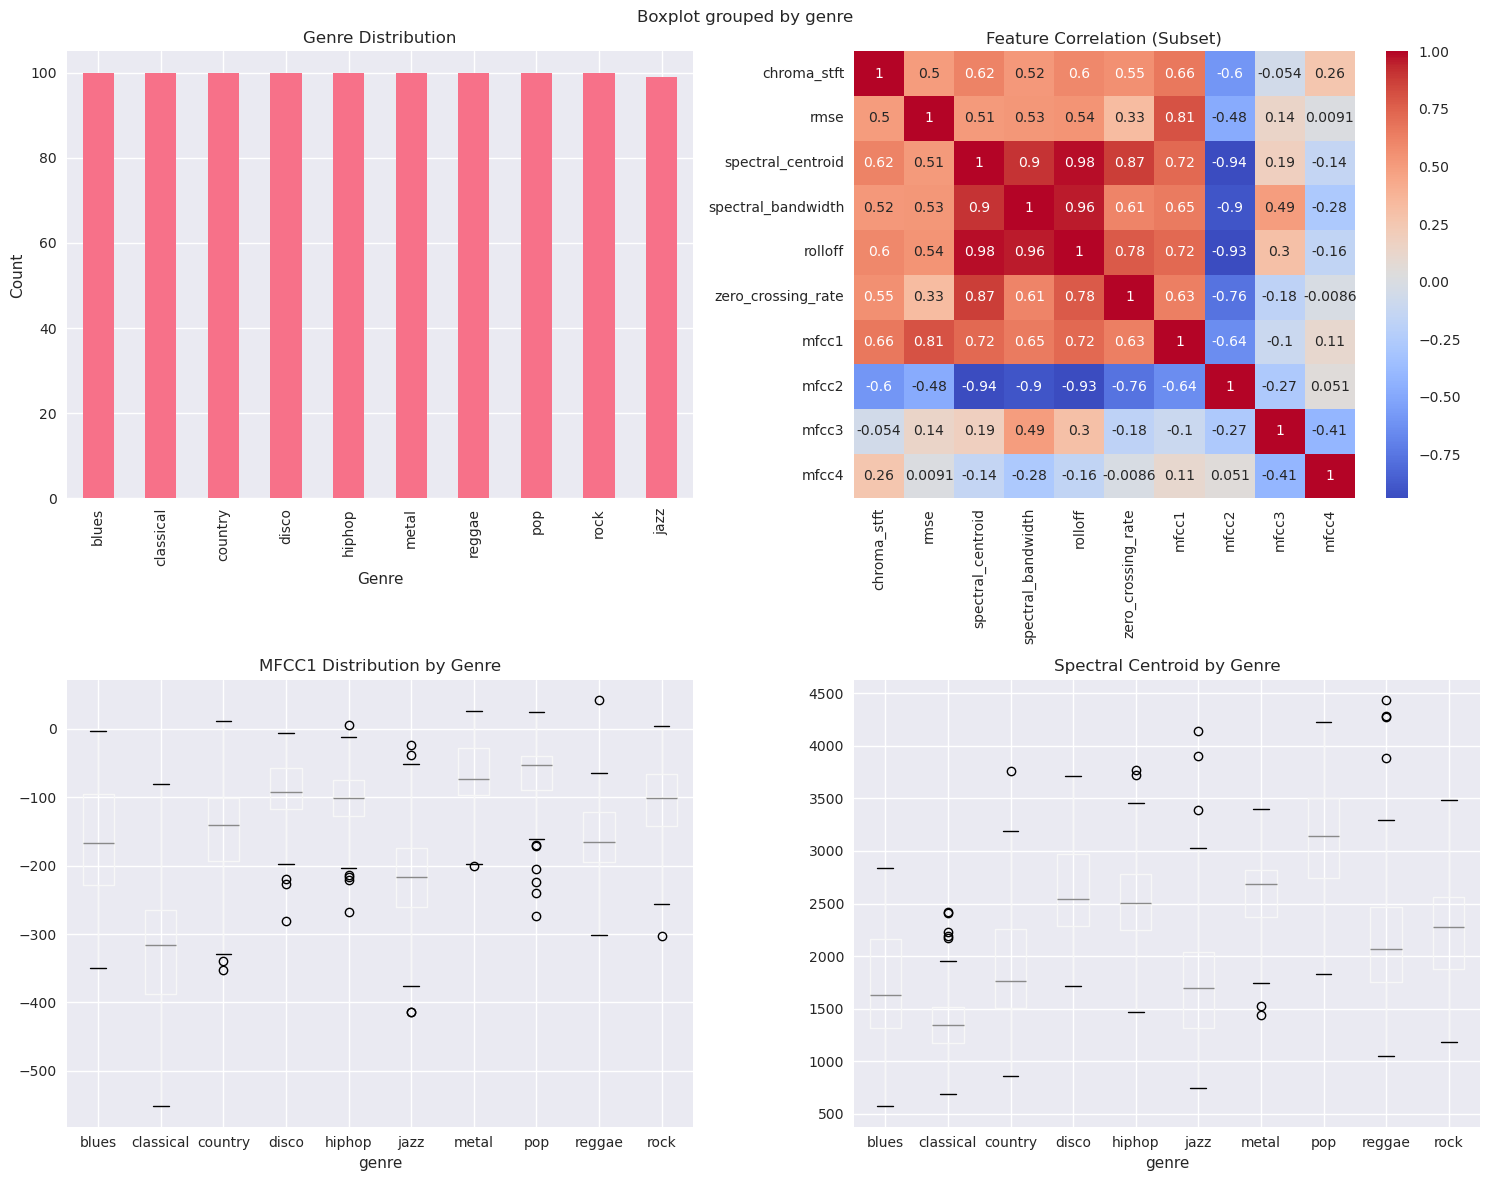


📈 Dataset Statistics:
       chroma_stft        rmse  spectral_centroid  spectral_bandwidth  \
count   999.000000  999.000000         999.000000          999.000000   
mean      0.378797    0.130843        2202.441329         2242.748051   
std       0.081683    0.065684         716.096608          526.560412   
min       0.171770    0.005270         570.150688          899.979779   
25%       0.319611    0.086536        1626.610837         1906.844369   
50%       0.383123    0.122231        2209.573799         2221.382901   
75%       0.435704    0.175749        2692.954240         2578.954341   
max       0.663541    0.397851        4434.948743         3509.582338   

           rolloff  zero_crossing_rate       mfcc1       mfcc2       mfcc3  \
count   999.000000          999.000000  999.000000  999.000000  999.000000   
mean   4572.989219            0.103676 -144.529678   99.529892   -8.930675   
std    1575.083232            0.041837  100.274345   31.334740   21.702673   
min    

In [7]:
"""
Load the dataset and explore its characteristics
This cell will take some time depending on your dataset size
"""

# Load dataset (uncomment when ready)
df = classifier.load_dataset(DATASET_PATH, sample_limit=SAMPLE_LIMIT)

# Explore dataset
stats = classifier.explore_dataset(df)
print("\n📈 Dataset Statistics:")
print(stats)

print("⚠️  Uncomment the above lines and update DATASET_PATH to load your data")

In [8]:
"""
Train the neural network model
This will take several minutes depending on your dataset size and hardware
"""

# Train model (uncomment when ready)
print("🚀 Starting training process...")
history, (X_test, y_test, y_pred) = classifier.train(
    df, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

print("⚠️  Uncomment the above lines to start training")

🚀 Starting training process...
🚀 Starting model training...
🔧 Preparing data for training...
Feature matrix shape: (999, 26)
Labels shape: (999,)
Unique genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Training set: 799 samples
Test set: 200 samples
✅ Data preparation completed!
🏗️ Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │        55,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,867,498 (10.94 MB)

 Trainable params: 2,860,330 (10.91 MB)

 Non-trainable params: 7,168 (28.00 KB)

🎯 Training in progress...
Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1249 - loss: 2.5691 - val_accuracy: 0.2550 - val_loss: 2.2935 - learning_rate: 1.0000e-04
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.1208 - loss: 2.4147 - val_accuracy: 0.2400 - val_loss: 2.2844 - learning_rate: 1.0000e-04
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.1815 - loss: 2.2661 - val_accuracy: 0.2600 - val_loss: 2.2707 - learning_rate: 1.0000e-04
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.1847 - loss: 2.2344 - val_accuracy: 0.2600 - val_loss: 2.2537 - learning_rate: 1.0000e-04
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.2178 - loss: 2.1435 - val_accuracy: 0.2900 - val_loss: 2.2338 - learning_rate: 1.0000e-04
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.2536 - loss: 2.0957 - val_accuracy: 0.3150 - val_loss: 2.2098 - learning_rate: 1.0000e-04
Epoch 7/1000
25/25 ━━━━━━━━━━━━

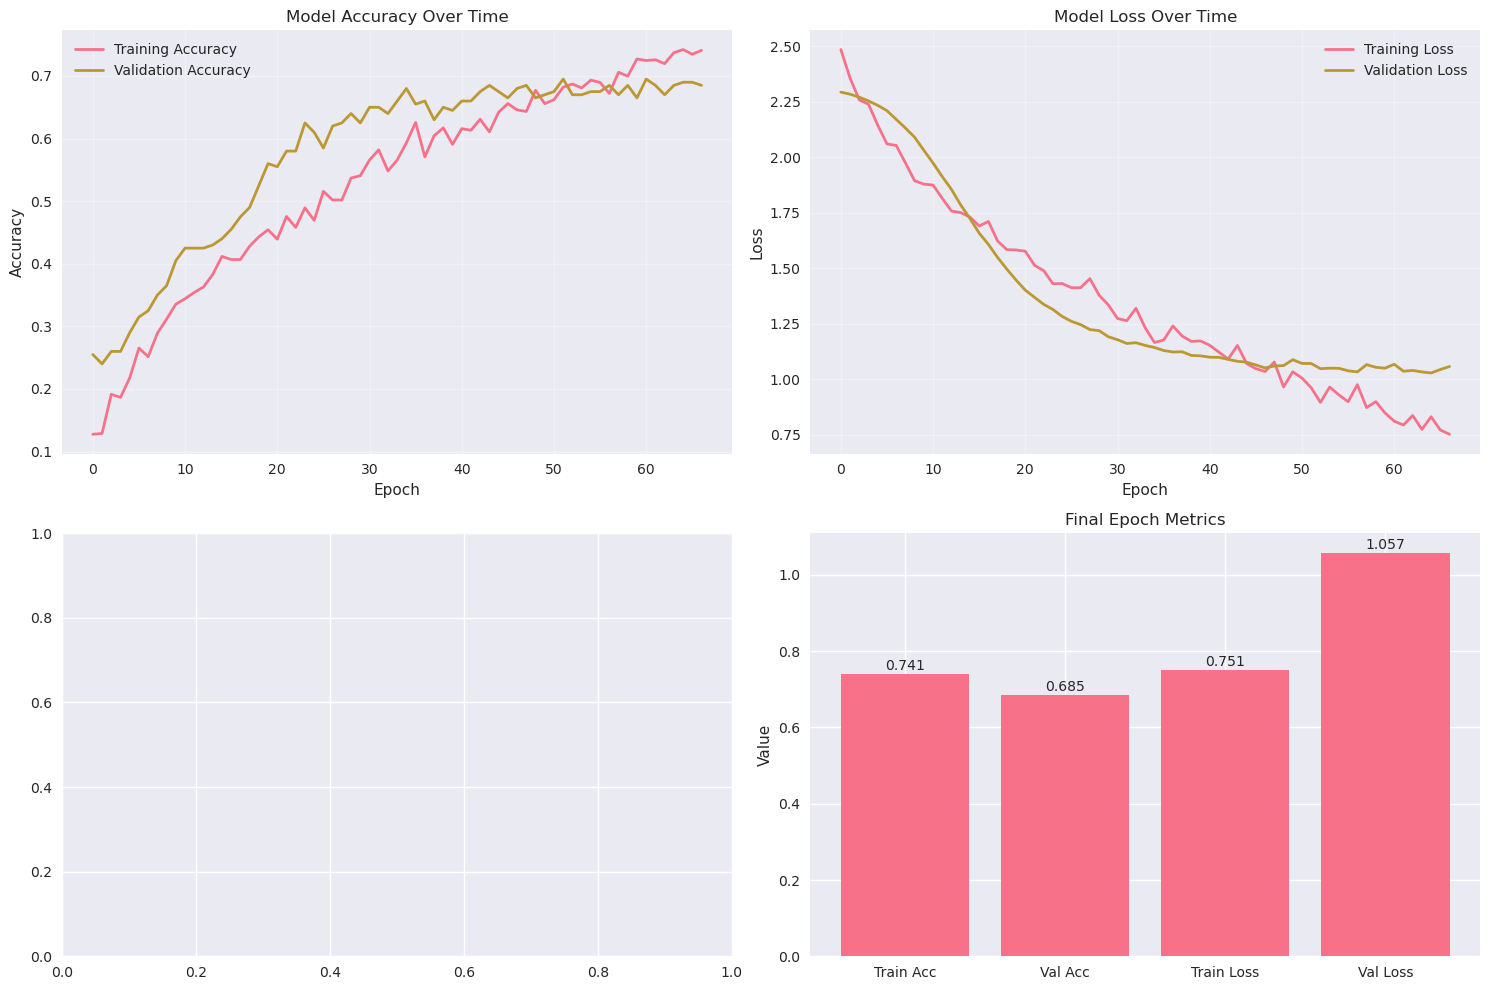

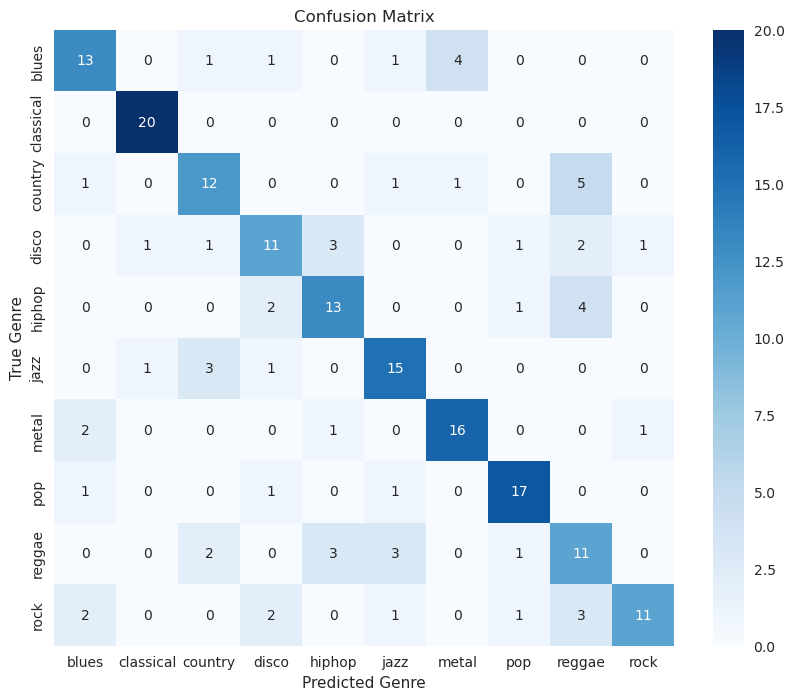

⚠️  Uncomment the above lines after training to see results


In [9]:
"""
Plot training history and model performance
"""

# Visualize training progress (uncomment after training)
classifier.plot_training_history()

# Plot confusion matrix (uncomment after training)
classifier.plot_confusion_matrix(y_test, y_pred)

print("⚠️  Uncomment the above lines after training to see results")

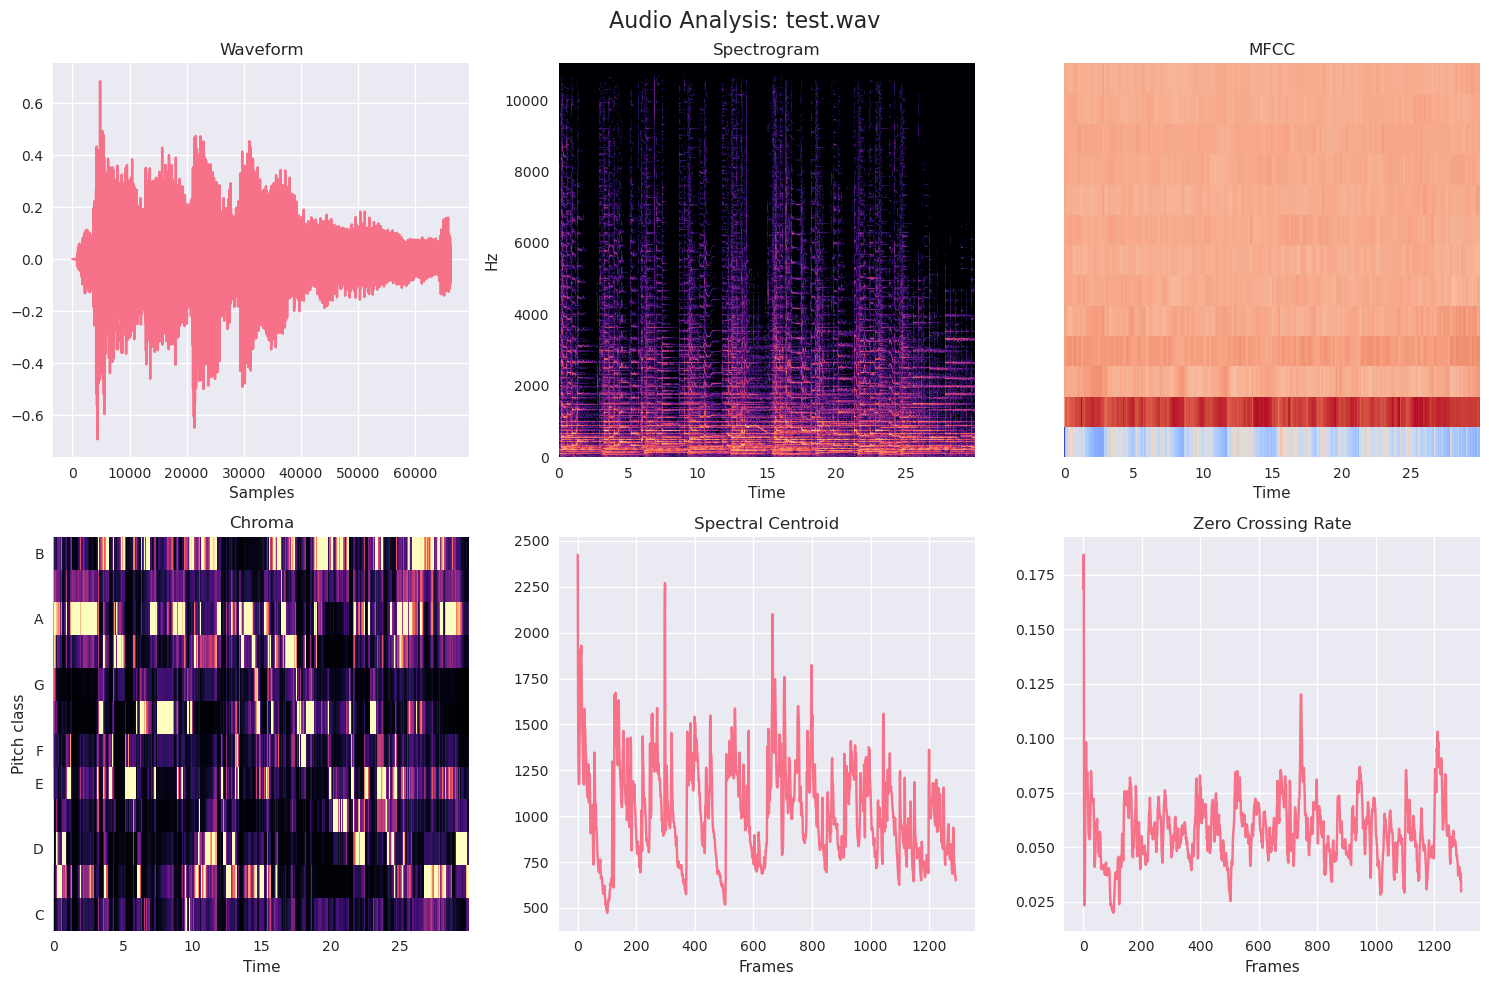

🎵 Analyzing: test.wav
🎯 Predicted Genre: jazz
🔥 Confidence: 0.535

📊 All Genre Probabilities:
  jazz: 0.535
  classical: 0.168
  country: 0.085
  reggae: 0.084
  pop: 0.051
  hiphop: 0.033
  blues: 0.021
  rock: 0.011
  metal: 0.006
  disco: 0.006
⚠️  Uncomment the above lines and update TEST_FILE path to test prediction


In [10]:
"""
Test the model on a single audio file
"""

# Test on a single file (uncomment and provide path after training)
TEST_FILE = "./test.wav"  # Update this path

# Visualize audio features
audio_widget = classifier.visualize_audio_features(TEST_FILE)
display(audio_widget)  # Play the audio

# Predict genre
result = classifier.predict_genre(TEST_FILE)

print("⚠️  Uncomment the above lines and update TEST_FILE path to test prediction")

In [11]:
"""
Save your trained model for future use
"""

# Save model (uncomment after training)
MODEL_NAME = "music_genre_classifier_v1"
classifier.save_model(MODEL_NAME)

# Load existing model (uncomment to load)
classifier.load_model(MODEL_NAME)

print("⚠️  Uncomment the above lines to save/load your model")

✅ Model saved as music_genre_classifier_v1_*


✅ Model loaded from music_genre_classifier_v1_*
⚠️  Uncomment the above lines to save/load your model


In [13]:
"""
Interactive widget for testing multiple files
"""

def create_interactive_tester():
    """
    Create an interactive widget for testing multiple files
    """
    from ipywidgets import interact, widgets
    from IPython.display import display, HTML
    
    def test_file(file_path):
        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            return
        
        try:
            result = classifier.predict_genre(file_path)
            audio_widget = Audio(file_path)
            display(audio_widget)
        except Exception as e:
            print(f"❌ Error: {e}")
    
    file_widget = widgets.Text(
        value='path/to/test/file.wav',
        placeholder='Enter audio file path',
        description='File Path:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )
    
    button = widgets.Button(description='Test File')
    
    def on_button_click(b):
        test_file(file_widget.value)
    
    button.on_click(on_button_click)
    
    display(widgets.VBox([file_widget, button]))

# Uncomment to create interactive tester (after training)
create_interactive_tester()

# print("🎉 Jupyter Notebook Setup Complete!")
# print("\n📋 Next Steps:")
# print("1. Update DATASET_PATH with your music dataset location")
# print("2. Run the dataset loading cell")
# print("3. Explore your data")
# print("4. Train the model")
# print("5. Evaluate results and test predictions")
# print("\n💡 Pro Tips:")
# print("• Start with a small dataset to test everything works")
# print("• Use GPU runtime for faster training")
# print("• Experiment with different network architectures")
# print("• Try data augmentation for better results")